# Task 2
Perform a similar operation to what described above, this time for Master students. Notice that this data is more tricky, as there are many missing records in the IS-Academia database. Therefore, try to guess how much time a master student spent at EPFL by at least checking the distance in months between Master semestre 1 and Master semestre 2. If the Mineur field is not empty, the student should also appear registered in Master semestre 3. Last but not the least, don't forget to check if the student has an entry also in the Projet Master tables. Once you can handle well this data, compute the "average stay at EPFL" for master students. Now extract all the students with a Spécialisation and compute the "average stay" per each category of that attribute -- compared to the general average, can you find any specialization for which the difference in average is statistically significant?

In [148]:
import requests
import urllib
import pandas as pd
from bs4 import BeautifulSoup
import numpy as np
import scipy.stats as stats
import matplotlib.pyplot as plt
import math
import pickle
import copy

# A. Generating a DataFrame with all the information from Master's students
1. Creating a dictionary for all the parameters
2. Creating a new dictionary for "Période Pédagogique"
3. Obtaining the DataFrames

## A1. Creating a dictionary for all the parameters

We will **follow the same procedure as we did in the task 1** when we worked with the data of the bachelor students.
We will still using the following values of the some of the parameters, this because, those will not change for getting the all the urlss and therefore, the reports:

* ww_x_GPS=-1                    "For 'tous' fixed"
* ww_i_reportModel=133685247     "fixed"
* ww_i_reportModelXsl=133685270  "fixed to HTML"
* ww_x_UNITE_ACAD=249847         "fixed to informatique"

This part is the same as in the Bachelor's part

In [149]:
#Add the base url where the form is
base_url = "http://isa.epfl.ch/imoniteur_ISAP/!gedpublicreports.htm?ww_i_reportmodel=133685247"
full_url = "http://isa.epfl.ch/imoniteur_ISAP/!GEDPUBLICREPORTS.filter?ww_b_list=1&ww_i_reportmodel=133685247&ww_c_langue=&ww_i_reportModelXsl=133685270&zz_x_UNITE_ACAD=&ww_x_UNITE_ACAD=249847&zz_x_PERIODE_ACAD=&ww_x_PERIODE_ACAD=213638028&zz_x_PERIODE_PEDAGO=&ww_x_PERIODE_PEDAGO=249108&zz_x_HIVERETE=&ww_x_HIVERETE=2936286&dummy=ok"

In [150]:
ww_x_GPS = '-1'  #for 'tous' fixed
ww_i_reportModel = '133685247'  #fixed
ww_i_reportModelXsl = '133685270'  #fixed to HTML
ww_x_UNITE_ACAD = '249847'  #fixed to informatique

In [151]:
r = requests.get( full_url )
soup = BeautifulSoup(r.text, 'lxml')

In [152]:
dicti = {}
for select in soup.findAll('select'):
    name = select['name'].strip()
    dicti[name] = {}
    for option in select.findAll('option'):
        #print( option.string, option['value'])
        if(option['value'] != 'null'):
            strng = option.string.strip()
            dicti[name][strng] = option['value'].strip()

In [153]:
dicti

{'ww_x_HIVERETE': {"Semestre d'automne": '2936286',
  'Semestre de printemps': '2936295'},
 'ww_x_PERIODE_ACAD': {'2007-2008': '978181',
  '2008-2009': '978187',
  '2009-2010': '978195',
  '2010-2011': '39486325',
  '2011-2012': '123455150',
  '2012-2013': '123456101',
  '2013-2014': '213637754',
  '2014-2015': '213637922',
  '2015-2016': '213638028',
  '2016-2017': '355925344'},
 'ww_x_PERIODE_PEDAGO': {'Bachelor semestre 1': '249108',
  'Bachelor semestre 2': '249114',
  'Bachelor semestre 3': '942155',
  'Bachelor semestre 4': '942163',
  'Bachelor semestre 5': '942120',
  'Bachelor semestre 5b': '2226768',
  'Bachelor semestre 6': '942175',
  'Bachelor semestre 6b': '2226785',
  'Master semestre 1': '2230106',
  'Master semestre 2': '942192',
  'Master semestre 3': '2230128',
  'Master semestre 4': '2230140',
  'Mineur semestre 1': '2335667',
  'Mineur semestre 2': '2335676',
  'Mise à niveau': '2063602308',
  'Projet Master automne': '249127',
  'Projet Master printemps': '3781783

## A2. Creating a new dictionary for "Période Pédagogique"

We need to create a new dictionary for the parameter "Période Pédagogique", this because we will only focus on the Master students and that parameter contains values for both master and bachelor. We will obtain this new dictionary from the previous one (the general one, "dict") and we will only consider the following values:
    
* Master semestre 1
* Master semestre 2
* Master semestre 3
* Master semestre 4
* Mineur semestre 1
* Mineur semestre 2
* Projet Master automne
* Projet Master printemps
* Stage printemps master

In [60]:
master_period_keys=['Master semestre 1','Master semestre 2','Master semestre 3','Master semestre 4',
               'Mineur semestre 1','Mineur semestre 2','Projet Master automne',
               'Projet Master printemps','Stage printemps master']
ww_x_PERIODE_PEDAGO_masters={key: dicti['ww_x_PERIODE_PEDAGO'][key] for key in master_period_keys}

In [61]:
ww_x_PERIODE_PEDAGO_masters

{'Master semestre 1': '2230106',
 'Master semestre 2': '942192',
 'Master semestre 3': '2230128',
 'Master semestre 4': '2230140',
 'Mineur semestre 1': '2335667',
 'Mineur semestre 2': '2335676',
 'Projet Master automne': '249127',
 'Projet Master printemps': '3781783',
 'Stage printemps master': '2227132'}

## A3. Obtaining the DataFrames

We will move trough the diferent permutations between the three parameters that we are interested (the other 4, as metioned before, are fixed):

* ww_x_PERIODE_ACAD "Période académique"
* ww_x_PERIODE_PEDAGO "Période pédagogique"
* ww_x_HIVERETE "Type de semestre"

We need to obtain the corresponding URL for each permutation and then we have to see whether the URL contains information (tables) or not, this in order to not have an error during the loops.

### No need to run the following cell!

In [154]:
#Counter for all the DataFrames
count_df=0  

#we create a list to store all the valid DataFrames
list_df_masters=[] 

#We define a new dictionary to get all the possible URLs that we are going to use, 
#notice that we are fixing some values as we mentioned before
params={}
params['ww_x_GPS']=ww_x_GPS #fixed
params['ww_i_reportModel']=ww_i_reportModel #fixed
params['ww_i_reportModelXsl']=ww_i_reportModelXsl #fixed
params['ww_x_UNITE_ACAD']=ww_x_UNITE_ACAD #fixed
params['ww_x_PERIODE_ACAD']='null' #this value will vary
params['ww_x_PERIODE_PEDAGO']='null' #this will vary
params['ww_x_HIVERETE']='null' #this value will vary

#We move trough the "Type de semestre" parameter
for semester_type_key, semester_type_value in dict['ww_x_HIVERETE'].items(): 
    
    #We move through the "Période pédagogique" parameter 
    for teaching_period_key,teaching_period_value in ww_x_PERIODE_PEDAGO_masters.items(): 
        
        #We move through the "Période académique" parameter
        for academic_period_key,academic_period_value in dict['ww_x_PERIODE_ACAD'].items(): 
            
            #We change the values for the three parameters so that we can get the new URL with the corresponding report
            params['ww_x_HIVERETE']=semester_type_value
            params['ww_x_PERIODE_PEDAGO']=teaching_period_value
            params['ww_x_PERIODE_ACAD']=academic_period_value
            
            #We get the HTML information with the new parameters for the URL
            urls=requests.get('http://isa.epfl.ch/imoniteur_ISAP/!GEDPUBLICREPORTS.html?',params) 
            
            try: #We need to see if the URL generates a report with tables to generate the DataFrame
                list_df_masters.append(pd.read_html(urls.url,header=0,skiprows=1,flavor='lxml')[0])
            except: 
                flag=0 #The flag has a "0" value if it finds a report with no information (no tables), this in order to not continue counting the dataframes. in this step no dataframe was created
            else:
                flag=1 #The flag has a "1" value if it finds a report with information (tables). in this point a dataFrame was created with the information of the corresponding report
            if flag==1: #If the dataframe was generated, then we need to add the columns with the academic period "Periode academique", teaching period "periode pedagofique" and semester type "Type de semestre"
                list_df_masters[count_df]['Periode academique']=academic_period_key
                list_df_masters[count_df]['Periode pedagogique']=teaching_period_key
                list_df_masters[count_df]['Type de semestre']=semester_type_key
                count_df=count_df+1 #We need to count how many dataframes are being created. 

In [87]:
#Finally, we concatenate all the dataframes from the list of dataframes to create one single DataFrame with all the information
'df_masters=pd.concat(list_df_masters,ignore_index=True)'

'df_masters=pd.concat(list_df_masters,ignore_index=True)'

### Pickling the DataFrame list

Since the list of DataFrame is computationally intensive, and we do not want to send the request to servers everytime, we saved the dataframes into another file, df_masters.p

The following cells do not need to be ran since df_masters is pickled already.

In [88]:
# saving the file
'pickle.dump(df_masters, open( "df_masters.p", "wb" ) )'

In [89]:
# opening the file
df_masters = pickle.load( open( "df_masters.p", "rb" ) )

In [90]:
# DataFrame with all the students ordered by timeline, this is to see each student's enrollment history.
df_masters.sort_values(by=['Nom Prénom', 'Periode academique', 'Type de semestre']).dropna(axis=1)

,Civilité,Nom Prénom,Statut,No Sciper,Periode academique,Periode pedagogique,Type de semestre
240,Madame,Abbadi Hajar,Présent,238067,2013-2014,Master semestre 1,Semestre d'automne
1925,Madame,Abbadi Hajar,Présent,238067,2013-2014,Master semestre 2,Semestre de printemps
1454,Madame,Abbadi Hajar,Présent,238067,2014-2015,Master semestre 3,Semestre d'automne
938,Monsieur,Abelenda Diego,Présent,170646,2010-2011,Master semestre 1,Semestre d'automne
2693,Monsieur,Abelenda Diego,Présent,170646,2010-2011,Master semestre 2,Semestre de printemps
1034,Monsieur,Abelenda Diego,Présent,170646,2011-2012,Master semestre 3,Semestre d'automne
1740,Monsieur,Abelenda Diego,Présent,170646,2011-2012,Master semestre 2,Semestre de printemps
415,Madame,Abi Akar Nora,Présent,251253,2015-2016,Master semestre 1,Semestre d'automne
2150,Madame,Abi Akar Nora,Présent,251253,2015-2016,Master semestre 2,Semestre de printemps
1535,Madame,Abi Akar Nora,Présent,251253,2016-2017,Master semestre 3,Semestre d'automne


In [121]:
# Examining the number of students in each group
df_masters.groupby('Periode pedagogique').count()['Nom Prénom']

Periode pedagogique
Master semestre 1           948
Master semestre 2          1062
Master semestre 3           706
Projet Master automne        86
Projet Master printemps      42
Name: Nom Prénom, dtype: int64

# B. Extracting information from DataFrame
1. Assumptions and demonstrating them
2. Calculating length of stay of each student
3. Statistical test of difference

## B1. Assumptions
1. We will include students that have started in 2016-2017, and ended in 2007-2008, even though we do not have complete data. Thus, Master's student's length will be shortened. However, since this shift applies to all specialization and gender, we keep this. This gives us more data, thus more possibilities for statistical significance.
2. If mineur is not empty, the student is also registered in Semester 3. I have tested this assumption (see following cell)
3. Everyone does a master's thesis (it is mandatory) http://ic.epfl.ch/computer-science/study-plan_master. There are values in the table, but only 58 values in 2016-2017, while around 2 in others. Since it is mandatory for everyone, I will add 6 months to the length of the Master's degree and ignore the table values.

In [122]:
df_minors = df_masters[df_masters.Mineur.notnull() & (df_masters['Periode academique'] != '2016-2017')].dropna(axis=1)
df_minors = df_masters[df_masters.Mineur.notnull() &
                       (df_masters['Periode academique'] != '2016-2017')
                      ].dropna(axis=1)
df_minors_sem3 = df_masters[df_masters.Mineur.notnull() &
                       (df_masters['Periode academique'] != '2016-2017') &
                       (df_masters['Periode pedagogique'] == 'Master semestre 3')
                      ].dropna(axis=1)

In [123]:
print('Num of students with minor:', df_minors['Nom Prénom'].unique().shape[0])
print('Num of students with minor and sem 3:', df_minors_sem3.shape[0])

Num of students with minor: 81
Num of students with minor and sem 3: 75


## B2. Average Stay of Student

Find the time elapsed between last term (Master's 2 or 3) to first term(Master's 1), excluding Master's thesis. Then add 6 months for Master's Thesis.

Produce the DataFrame that contains name, gender, first term's year, first term's semester, spécialisation, last term's year, last term's semester, time elapsed. The result is stored in df_dur.

In [124]:
df = df_masters

In [133]:
df = df[df['Periode pedagogique'].isin(['Master semestre 1','Master semestre 2', 'Master semestre 3'])].sort_values(by=['Nom Prénom', 'Periode academique', 'Type de semestre'])

In [134]:
# extracting year and semester
df['year'] = df['Periode academique'].str[0:4].astype(int)
df['semester'] = np.where(df['Type de semestre'] == "Semestre d'automne", 0,1)
df = df[df['Periode pedagogique'].isin(['Master semestre 1','Master semestre 2', 'Master semestre 3'])].sort_values(by=['Nom Prénom', 'Periode academique', 'Type de semestre'])

In [135]:
# orgnaization

#First master semester df
first_row = df.groupby('Nom Prénom').first()
first_row.rename(columns={'year':'first_year', 'semester':'first_semester'}, inplace=True)
first_row = first_row[['Civilité','first_year','first_semester','Spécialisation']]
first_row.reset_index(inplace=True)

#Last master semester df
last_row = df.groupby('Nom Prénom').last()
last_row.rename(columns={'year':'last_year', 'semester':'last_semester'}, inplace=True)
last_row = last_row[['Civilité','last_year','last_semester','Spécialisation']]
last_row.reset_index(inplace=True)

In [139]:
# df_dur is the DataFrame with all the necessary information, combining gender, along with the average stay
df_dur = first_row.merge(last_row)

We calculate the duration in terms of number of months, assuming one semester is 6 months.
+ Duration = (Number of years) + (Adjusting for whether the first and last semester is autumn or spring) + (Time for masters thesis)
+ Number of years = (last year - first year)*12
+ Adjustment = (last_semester - first_semester + 1)*6, (last_semester and first_semester are as defined in the above cell)
+ Theses = 6


In [140]:
df_dur['Duration in Months'] = (df_dur['last_year'] - df_dur['first_year'])*12 + (df_dur['last_semester'] - df_dur['first_semester'] + 1)*6 + 6 

In [141]:
df_dur.head()

,Nom Prénom,Civilité,first_year,first_semester,Spécialisation,last_year,last_semester,Duration in Months
0,Abbadi Hajar,Madame,2013,0,NaN,2014,0,24
1,Abelenda Diego,Monsieur,2010,0,"Signals, Images and Interfaces",2011,1,30
2,Abi Akar Nora,Madame,2015,0,NaN,2016,0,24
3,Adamsons Valdis,Monsieur,2016,0,NaN,2016,0,12
4,Adams Marc Alain,Monsieur,2016,0,NaN,2016,0,12


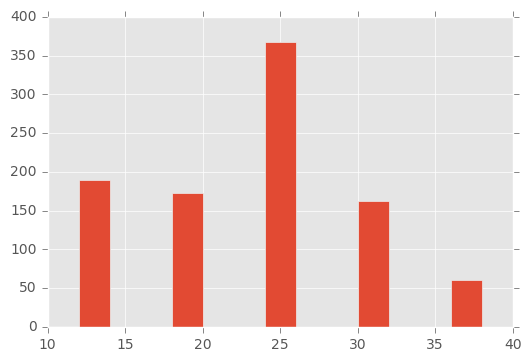

In [157]:
import matplotlib.pyplot as plt
import matplotlib
matplotlib.style.use('ggplot')
%matplotlib inline

df_dur['Duration in Months'].hist(bins = 15, range=[10, 40])

## B3. Statistical Tests

Extract all the students with a Spécialisation and compute the "average stay" per each category of that attribute.

Compare the general average with each specialization, and find statistically significant average difference.

### Null Hypotheses:

There is no difference between the average stay at EPFL between all students in Informatique and students in specialization_X, where specialization_X is one of specialization in spec_list.

In [142]:
spec_list = df_dur['Spécialisation'].unique()
spec_list # list of specializations

array([nan, 'Signals, Images and Interfaces', 'Internet computing',
       'Internet Information Systems', 'Foundations of Software',
       'Information Security - SP', 'Software Systems', 'Biocomputing',
       'Computer Engineering - SP', 'Data Analytics', 'Service science',
       'Computer Science Theory'], dtype=object)

In [143]:
# a list of all the duration for all the specialization, held in series.
spec_series_list = [] # list of series
for specialization in spec_list:
    spec_series_list.append(df_dur['Duration in Months'][df_dur['Spécialisation'] == specialization])

In [144]:
# the series with the average stay of all students
spec_general = df_dur['Duration in Months']
spec_general.mean() # mean of average stay of all students in Informatique

22.70236869207003

### P values of each specialization
Whether there is a significant difference between each specialization and general. We use the same test we used for the bachelors part.

In [158]:
for i in range(len(spec_series_list)):
    print(spec_list[i], ":", stats.ttest_ind(a= spec_series_list[i], b= spec_general,equal_var=False),'\n')

nan : Ttest_indResult(statistic=nan, pvalue=nan) 

Signals, Images and Interfaces : Ttest_indResult(statistic=2.4341566990844106, pvalue=0.019683226653819778) 

Internet computing : Ttest_indResult(statistic=5.2250932188177099, pvalue=6.8201547995532931e-07) 

Internet Information Systems : Ttest_indResult(statistic=nan, pvalue=nan) 

Foundations of Software : Ttest_indResult(statistic=5.180365920874058, pvalue=1.7179068131919869e-06) 

Information Security - SP : Ttest_indResult(statistic=2.6601879741282644, pvalue=0.034392493329394445) 

Software Systems : Ttest_indResult(statistic=1.5162351278301907, pvalue=0.14661272099207276) 

Biocomputing : Ttest_indResult(statistic=-1.5449946953694298, pvalue=0.15018581715836868) 

Computer Engineering - SP : Ttest_indResult(statistic=3.0015067299349298, pvalue=0.0064402924337378471) 

Data Analytics : Ttest_indResult(statistic=-1.3767639508146383, pvalue=0.21661211458894009) 

Service science : Ttest_indResult(statistic=1.6371048709331744, pva

/home/kirtan/anaconda3/lib/python3.5/site-packages/numpy/core/_methods.py:82: RuntimeWarning: Degrees of freedom <= 0 for slice
  warnings.warn("Degrees of freedom <= 0 for slice", RuntimeWarning)


### Results

The results make intuitive sense because the specializations with enough students as samples came out to be statistically significantly different. In addition, there is also a average length difference with the general student population.

In [161]:
# average length of each specialization
df_dur.groupby('Spécialisation').mean()['Duration in Months']

Spécialisation
Biocomputing                      18.500000
Computer Engineering - SP         26.454545
Computer Science Theory           24.000000
Data Analytics                    19.714286
Foundations of Software           27.441176
Information Security - SP         25.714286
Internet Information Systems      24.000000
Internet computing                26.628571
Service science                   26.000000
Signals, Images and Interfaces    27.000000
Software Systems                  24.666667
Name: Duration in Months, dtype: float64

In [162]:
# number of students of each specialization
df_dur.groupby('Spécialisation').count()['Duration in Months']

Spécialisation
Biocomputing                       12
Computer Engineering - SP          22
Computer Science Theory             1
Data Analytics                      7
Foundations of Software            68
Information Security - SP           7
Internet Information Systems        1
Internet computing                105
Service science                     3
Signals, Images and Interfaces     38
Software Systems                   18
Name: Duration in Months, dtype: int64